# MissOh DataLoader

### AnotherMissOh Visual Structure
- json_data['file_name'] : 'AnotherMissOh01.mp4'
- json_data['visual_results']
- json_data['visual_results'][0].keys() : dict_keys(['start_time', 'end_time', 'vid', 'image_info'])
- {
'start_time': '00:02:51;16', 
'end_time': '00:02:54;15', 
'vid': 'AnotherMissOh01_001_0078', 
'image_info': ...}
- json_data['visual_results'][0]['image_info']
- [{'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004295', 
'place': 'none', 
'persons': [
{'person_id': 'Haeyoung1', 
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 845, 'max_y': 443}, 
'full_rect': {'min_x': 278, 'min_y': 2, 'max_x': 1025, 'max_y': 769}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}], 
'objects': []}, 
- {'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004311', 
'place': '', 
'persons': [{
'person_id':'Haeyoung1',
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 831, 'max_y': 411}, 
'full_rect': {'min_x': 270, 'min_y': 0, 'max_x': 1025, 'max_y': 768}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}],
'objects': []},]

In [10]:
# !apt-get install graphviz xdg-utils

In [11]:
import sys, os
sys.path.append("../") # go to parent dir

In [12]:
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import pickle
import numpy as np
import glob
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import json
import argparse
import matplotlib.pyplot as plt

from Yolo_v2_pytorch.src.utils import *
from graphviz import Digraph, Graph

In [13]:
def is_not_blank(s):
    return bool(s and s.strip())

In [14]:
MissOh_CLASSES = ['person']
print(MissOh_CLASSES[0])
global colors
colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))
print(colors[0])

person
(39, 129, 113)


In [15]:
import sys, os
sys.path.append("../") # go to parent dir

In [16]:
import os
import glob
import argparse
import pickle
import cv2
import numpy as np
from Yolo_v2_pytorch.src.utils import *
import torch.nn.functional as F
from torch.utils.data import DataLoader
from Yolo_v2_pytorch.src.yolo_net import Yolo
from Yolo_v2_pytorch.src.anotherMissOh_dataset import AnotherMissOh, Splits, SortFullRect, PersonCLS,PBeHavCLS, FaceCLS, ObjectCLS, P2ORelCLS
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import time

from lib.place_model import place_model, label_mapping, accuracy, label_remapping, place_buffer
from lib.person_model import person_model
from lib.behavior_model import behavior_model
from lib.pytorch_misc import optimistic_restore, de_chunkize, clip_grad_norm, flatten
from lib.focal_loss import FocalLossWithOneHot, FocalLossWithOutOneHot, CELossWithOutOneHot
from lib.face_model import face_model
from lib.object_model import object_model
from lib.relation_model import relation_model
from lib.emotion_model import emotion_model, crop_face_emotion, EmoCLS

num_persons = len(PersonCLS)
num_behaviors = len(PBeHavCLS)
num_faces = len(FaceCLS)
num_objects = len(ObjectCLS)
num_relations = len(P2ORelCLS)
num_emos = len(EmoCLS)

def get_args():
    parser = argparse.ArgumentParser(
        "You Only Look Once: Unified, Real-Time Object Detection")
    parser.add_argument("--image_size",
                        type=int, default=448,
                        help="The common width and height for all images")
    parser.add_argument("--batch_size", type=int, default=1,
                        help="The number of images per batch")
    parser.add_argument("--conf_threshold",
                        type=float, default=0.35)
    parser.add_argument("--nms_threshold",
                        type=float, default=0.5)
    parser.add_argument("--pre_trained_model_type",
                        type=str, choices=["model", "params"],
                        default="model")
    parser.add_argument("--data_path_test",
                        type=str,
                        default="./Yolo_v2_pytorch/missoh_test/",
                        help="the root folder of dataset")

    parser.add_argument("--saved_path", type=str,
                        default="./checkpoint/refined_models")

    parser.add_argument("--img_path", type=str,
                        default="./data/AnotherMissOh/AnotherMissOh_images_ver3.2/")
    parser.add_argument("--json_path", type=str,
                        default="./data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/")
    parser.add_argument("-model", dest='model', type=str, default="baseline")
    parser.add_argument("-display", dest='display', action='store_true')
    parser.add_argument("-emo_net_ch", dest='emo_net_ch',type=int, default=64)
    args = parser.parse_args([])
    return args

# get args.
opt = get_args()
print(opt)

Namespace(batch_size=1, conf_threshold=0.35, data_path_test='./Yolo_v2_pytorch/missoh_test/', display=False, emo_net_ch=64, image_size=448, img_path='./data/AnotherMissOh/AnotherMissOh_images_ver3.2/', json_path='./data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/', model='baseline', nms_threshold=0.5, pre_trained_model_type='model', saved_path='./checkpoint/refined_models')


In [17]:
opt.img_path = "../data/AnotherMissOh/AnotherMissOh_images_ver3.2/"
opt.json_path = "../data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/"
opt.saved_path = "../checkpoint/refined_models"
opt.display = True

In [18]:
tform = [
    Resize((448, 448)),  # should match to Yolo_V2
    ToTensor(),
    # Normalize(# should match to Yolo_V2
    #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
transf = Compose(tform)

# splits the episodes int train, val, test
train, val, test = Splits(num_episodes=18)

# load datasets
train_set = AnotherMissOh(train, opt.img_path, opt.json_path, False)
val_set = AnotherMissOh(val, opt.img_path, opt.json_path, False)
test_set = AnotherMissOh(test, opt.img_path, opt.json_path, False)

# model path
model_path = "{}/anotherMissOh_{}.pth".format(
    opt.saved_path,opt.model)

In [19]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)
    device = torch.cuda.current_device()
else:
    torch.manual_seed(123)

# set test loader params
test_params = {"batch_size": opt.batch_size,
               "shuffle": False,
               "drop_last": False,
               "collate_fn": custom_collate_fn}

# set test loader
test_loader = DataLoader(test_set, **test_params)

# ---------------(1) load refined models --------------------
# get the trained models from
# https://drive.google.com/drive/folders/1WXzP8nfXU4l0cNOtSPX9O1qxYH2m6LIp

# face model
if True:
    model_face = face_model(num_persons, num_faces, device)
    trained_face = '../checkpoint/refined_models' + os.sep + "{}".format(
    'anotherMissOh_only_params_face.pth')
    model_face.load_state_dict(torch.load(trained_face))
    print("loaded with {}".format(trained_face))
model_face.cuda(device)
model_face.eval()

True
loaded with ../checkpoint/refined_models/anotherMissOh_only_params_face.pth


face_model(
  (detector): YoloD(
    (stage1_conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (stage1_conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (stage1_conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inpla

In [20]:
# load the color map for detection results
colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))

width, height = (1024, 768)
width_ratio = float(opt.image_size) / width
height_ratio = float(opt.image_size) / height

/usr/local/envs/vtt_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002414.txt
non-detected ./results/drama-graph/AnotherMissOh07/001/0035/IMAGE_0000002414.jpg


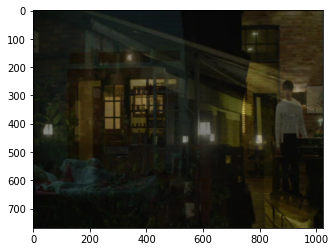

frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002422.txt
non-detected ./results/drama-graph/AnotherMissOh07/001/0035/IMAGE_0000002422.jpg


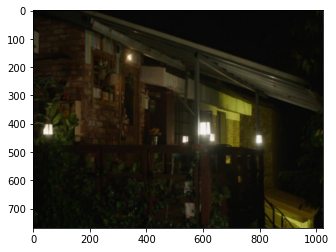

frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002430.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002438.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002446.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002454.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002462.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002470.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002478.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002486.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002600.txt
non-detected ./results/drama-graph/AnotherMissOh07/002/0036/IMAGE_0000002600.jpg


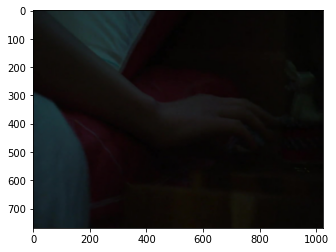

frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002608.txt
non-detected ./results/drama-graph/AnotherMissOh07/002/0036/IMAGE_0000002608.jpg
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002616.txt
non-detected ./results/drama-graph/AnotherMissOh07/002/0036/IMAGE_0000002616.jpg


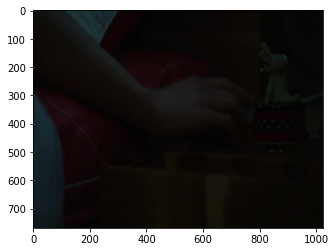

frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002680.txt
non-detected ./results/drama-graph/AnotherMissOh07/002/0036/IMAGE_0000002680.jpg


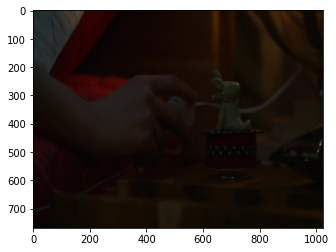

frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002672.txt
non-detected ./results/drama-graph/AnotherMissOh07/002/0036/IMAGE_0000002672.jpg


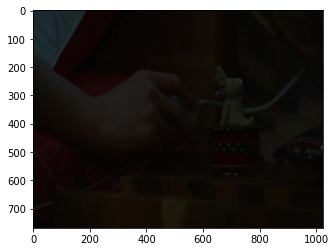

frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002664.txt
non-detected ./results/drama-graph/AnotherMissOh07/002/0036/IMAGE_0000002664.jpg


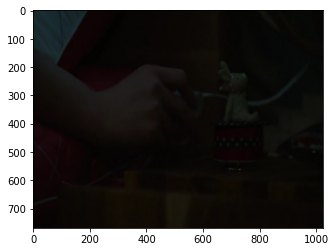

frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002656.txt
non-detected ./results/drama-graph/AnotherMissOh07/002/0036/IMAGE_0000002656.jpg


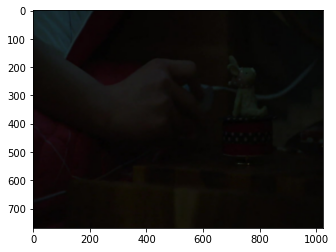

frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002648.txt
non-detected ./results/drama-graph/AnotherMissOh07/002/0036/IMAGE_0000002648.jpg


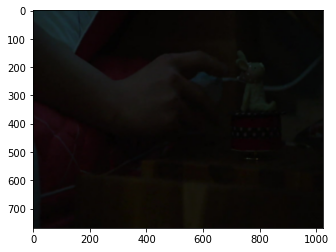

In [ ]:
# Sequence buffers
buffer_images = []
# load test clips
for iter, batch in enumerate(test_loader):
    image, info = batch

    # sort label info on fullrect
    image, label, behavior_label, obj_label, face_label, emo_label, frame_id = SortFullRect(
        image, info, is_train=False)

    try :
        image = torch.cat(image,0).cuda(device)
    except:
        continue

    # -----------------(2) inference -------------------------
    # face
    if np.array(face_label).size > 0 :
        face_logits = model_face(image)
        predictions_face = post_processing(face_logits,
                                           opt.image_size,
                                           FaceCLS,
                                           model_face.detector.anchors,
                                           opt.conf_threshold,
                                           opt.nms_threshold)
    
    for idx, frame in enumerate(frame_id):

        # ---------------(3) mkdir for evaluations----------------------
        f_info = frame[0].split('/')
        save_dir = './results/drama-graph/{}/{}/{}/'.format(
            f_info[4], f_info[5], f_info[6])

        f_file = f_info[7]
        mAP_file = "{}_{}_{}_{}".format(f_info[4],
                                        f_info[5],
                                        f_info[6],
                                        f_info[7].replace("jpg", "txt"))
        if opt.display:
            print("frame.__len__{}, mAP_file:{}".format(len(frame_id), mAP_file))
            
        # --------------(5) visualization of inferences ----------
        # out of try : pdb.set_trace = lambda : None
        try:
            # for some empty video clips
            img = image[idx]
            # ToTensor function normalizes image pixel values into [0,1]
            np_img = img.cpu().numpy()
            np_img = np.transpose(np_img,(1,2,0)) * 255
            output_image = cv2.cvtColor(np_img,cv2.COLOR_RGB2BGR)
            output_image = cv2.resize(output_image, (width, height))
    
            # face
            if len(predictions_face) != 0:
                prediction_face = predictions_face[idx]
                for pred in prediction_face:
                    xmin = int(max(pred[0] / width_ratio, 0))
                    ymin = int(max(pred[1] / height_ratio, 0))
                    xmax = int(min((pred[2]) / width_ratio, width))
                    ymax = int(min((pred[3]) / height_ratio, height))
                    color = colors[FaceCLS.index(pred[5])]
                    
                    cv2.rectangle(output_image, (xmin, ymin),
                                  (xmax, ymax), color, 2)
                    text_size = cv2.getTextSize(
                        pred[5] + ' : %.2f' % pred[4],
                        cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                    cv2.rectangle(
                        output_image,
                        (xmin, ymin),
                        (xmin + text_size[0] + 100,
                         ymin + text_size[1] + 20), color, -1)
                    cv2.putText(
                        output_image, pred[5] + ' : %.2f' % pred[4],
                        (xmin, ymin + text_size[1] + 4),
                        cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 1)
                    
                    # save detection results
                    pred_cls = pred[5]
                    cat_pred = '%s %s %s %s %s %s\n' % (
                        pred_cls,
                        str(pred[4]),
                        str(xmin), str(ymin), str(xmax), str(ymax))
                    
                    print("face_pred:{}".format(cat_pred))
                    print("detected {}".format(
                        save_dir + "{}".format(f_file)))
            else:
                print("non-detected {}".format(
                        save_dir + "{}".format(f_file)))
            # save output image  
            cv2.imwrite(save_dir + "{}".format(f_file), output_image)
            # save images
            plt_output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
            plt.imshow(plt_output_image.astype('uint8'))
            plt.show()
            plt.close()
        except:
            continue